In [1]:
pip install scikeras

In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [4]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [5]:

def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [6]:
from optuna.samplers import GridSampler

def run_optuna_optimization_grid_search(X_train, y_train, X_test, y_test, n_steps):
    def lstm_objective(trial):
        # Initialize scalers
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))

        # Normalize features and targets
        X_train_scaled = scaler_x.fit_transform(X_train)
        X_test_scaled = scaler_x.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

        # Create sequences
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

        # Hyperparameters

        lstm_units = trial.suggest_categorical('lstm_units', [50, 100])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, log=True)


        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    # Grid search space
    search_space = {
        'lstm_units': [50, 100],
        'dropout_rate': [0.1, 0.2],
        'learning_rate': [0.001, 0.01]
    }

    # Optuna study with GridSampler
    study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
    study.optimize(lstm_objective, n_trials=8)

    best_trial = study.best_trial
    # Re-train the best model to get predictions for visualization
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
     )
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)


   # After retraining the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

# Recalculate metrics for the retrained model
    final_train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
    final_train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
    final_test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
    final_test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

# Update the results dictionary with the new metrics
    results = {
    'Feature Engineering Method': 'Method Name',  # Update with actual method name
    'Best Trial Train MAE': final_train_mae,
    'Best Trial Train RMSE': final_train_rmse,
    'Best Trial Test MAE': final_test_mae,
    'Best Trial Test RMSE': final_test_rmse,
    'Best Params': best_trial.params
    }



    return results, pred_list

In [7]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without Feature Engineering': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization_grid_search(X_train, y_train, X_test, y_test, n_steps)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-03-26 22:35:59,107] A new study created in memory with name: no-name-21ee1ec8-cb42-4275-9346-a681488921bb



####### Without Feature Engineering #######
9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:37:18,640] Trial 0 finished with value: 7.444987557045691 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 7.444987557045691.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:38:06,850] Trial 1 finished with value: 8.065559945441452 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 7.444987557045691.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:39:14,428] Trial 2 finished with value: 13.940659362757591 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 7.444987557045691.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:40:02,086] Trial 3 finished with value: 12.884090466794477 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 7.444987557045691.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:40:50,276] Trial 4 finished with value: 13.243018459505072 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 7.444987557045691.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:41:24,581] Trial 5 finished with value: 6.276323206227873 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 5 with value: 6.276323206227873.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:42:54,032] Trial 6 finished with value: 9.40507792359679 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 5 with value: 6.276323206227873.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:44:01,090] Trial 7 finished with value: 5.98806650928538 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 7 with value: 5.98806650928538.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:45:31,108] A new study created in memory with name: no-name-9e5df196-624d-4439-a6b9-db3a323f6bd6



####### Boruta #######
9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:47:00,650] Trial 0 finished with value: 10.0765493121831 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 0 with value: 10.0765493121831.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:47:34,460] Trial 1 finished with value: 5.261840557632334 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 1 with value: 5.261840557632334.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:49:04,426] Trial 2 finished with value: 8.302250301662331 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 1 with value: 5.261840557632334.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:49:39,856] Trial 3 finished with value: 8.180926114893909 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 1 with value: 5.261840557632334.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:50:14,887] Trial 4 finished with value: 10.679839126461625 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 1 with value: 5.261840557632334.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:51:03,629] Trial 5 finished with value: 7.284022229643037 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 1 with value: 5.261840557632334.


9/9 [==============================] - 0s 7ms/step


[I 2024-03-26 22:52:11,708] Trial 6 finished with value: 4.954845563687301 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 6 with value: 4.954845563687301.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-26 22:53:21,020] Trial 7 finished with value: 6.925499820451456 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 6 with value: 4.954845563687301.


9/9 [==============================] - 0s 7ms/step


[I 2024-03-26 22:54:33,298] A new study created in memory with name: no-name-25f62939-17c4-463d-81c1-2980c312efd1



####### PCA #######
9/9 [==============================] - 0s 11ms/step


[I 2024-03-26 22:56:03,174] Trial 0 finished with value: 79.69478107471687 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 79.69478107471687.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:56:51,870] Trial 1 finished with value: 78.3804103853244 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 1 with value: 78.3804103853244.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:57:39,688] Trial 2 finished with value: 76.50436731769187 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 76.50436731769187.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 22:58:15,867] Trial 3 finished with value: 78.35644316499855 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 2 with value: 76.50436731769187.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 22:59:21,289] Trial 4 finished with value: 79.42142533283544 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 2 with value: 76.50436731769187.


9/9 [==============================] - 0s 7ms/step


[I 2024-03-26 23:00:25,653] Trial 5 finished with value: 78.35667032269676 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 2 with value: 76.50436731769187.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 23:01:14,013] Trial 6 finished with value: 76.33984227218411 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 6 with value: 76.33984227218411.


9/9 [==============================] - 0s 7ms/step


[I 2024-03-26 23:02:45,434] Trial 7 finished with value: 77.64097298648566 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 6 with value: 76.33984227218411.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 23:03:21,299] A new study created in memory with name: no-name-187896e7-4711-4189-bcc1-a9b4636cbefc



####### t-SNE #######
9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 23:04:25,485] Trial 0 finished with value: 76.79314872631163 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 0 with value: 76.79314872631163.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-26 23:05:55,142] Trial 1 finished with value: 74.44710544727764 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 23:06:42,764] Trial 2 finished with value: 76.27340854179262 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 11ms/step


[I 2024-03-26 23:07:51,213] Trial 3 finished with value: 74.76588727222226 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 23:08:39,803] Trial 4 finished with value: 75.82006101332648 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-26 23:09:12,590] Trial 5 finished with value: 75.65432792177282 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 7ms/step


[I 2024-03-26 23:10:42,012] Trial 6 finished with value: 78.03665563003715 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 1 with value: 74.44710544727764.


9/9 [==============================] - 0s 6ms/step


[I 2024-03-26 23:11:15,957] Trial 7 finished with value: 71.46902974108777 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.001}. Best is trial 7 with value: 71.46902974108777.


9/9 [==============================] - 0s 4ms/step
    Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0  Without Feature Engineering              2.423010               3.391257   
1                       Boruta              2.747061               3.704195   
2                          PCA              2.593193               3.737159   
3                        t-SNE              2.358337               3.502814   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             5.251492              6.724581   
1             7.685670              9.174028   
2             6.650325              8.633482   
3             9.287235             10.945543   

                                         Best Params  
0  {'lstm_units': 100, 'dropout_rate': 0.2, 'lear...  
1  {'lstm_units': 100, 'dropout_rate': 0.2, 'lear...  
2  {'lstm_units': 50, 'dropout_rate': 0.1, 'learn...  
3  {'lstm_units': 50, 'dropout_rate': 0.1, 'learn...  


In [8]:
results_total


[{'Feature Engineering Method': 'Without Feature Engineering',
  'Best Trial Train MAE': 2.4230103678815067,
  'Best Trial Train RMSE': 3.3912571967666003,
  'Best Trial Test MAE': 5.25149231216947,
  'Best Trial Test RMSE': 6.724581194631394,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.2,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.747061295829407,
  'Best Trial Train RMSE': 3.7041945531448097,
  'Best Trial Test MAE': 7.685669864761117,
  'Best Trial Test RMSE': 9.174027751711861,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.2,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 2.593192937917301,
  'Best Trial Train RMSE': 3.73715928140817,
  'Best Trial Test MAE': 6.650325065801532,
  'Best Trial Test RMSE': 8.6334819436504,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.1,
   'learning_rate': 0.01}},
 {'Feature Engineering Method': 't-SNE',
  'Best Tr

In [ ]:
predictions_total

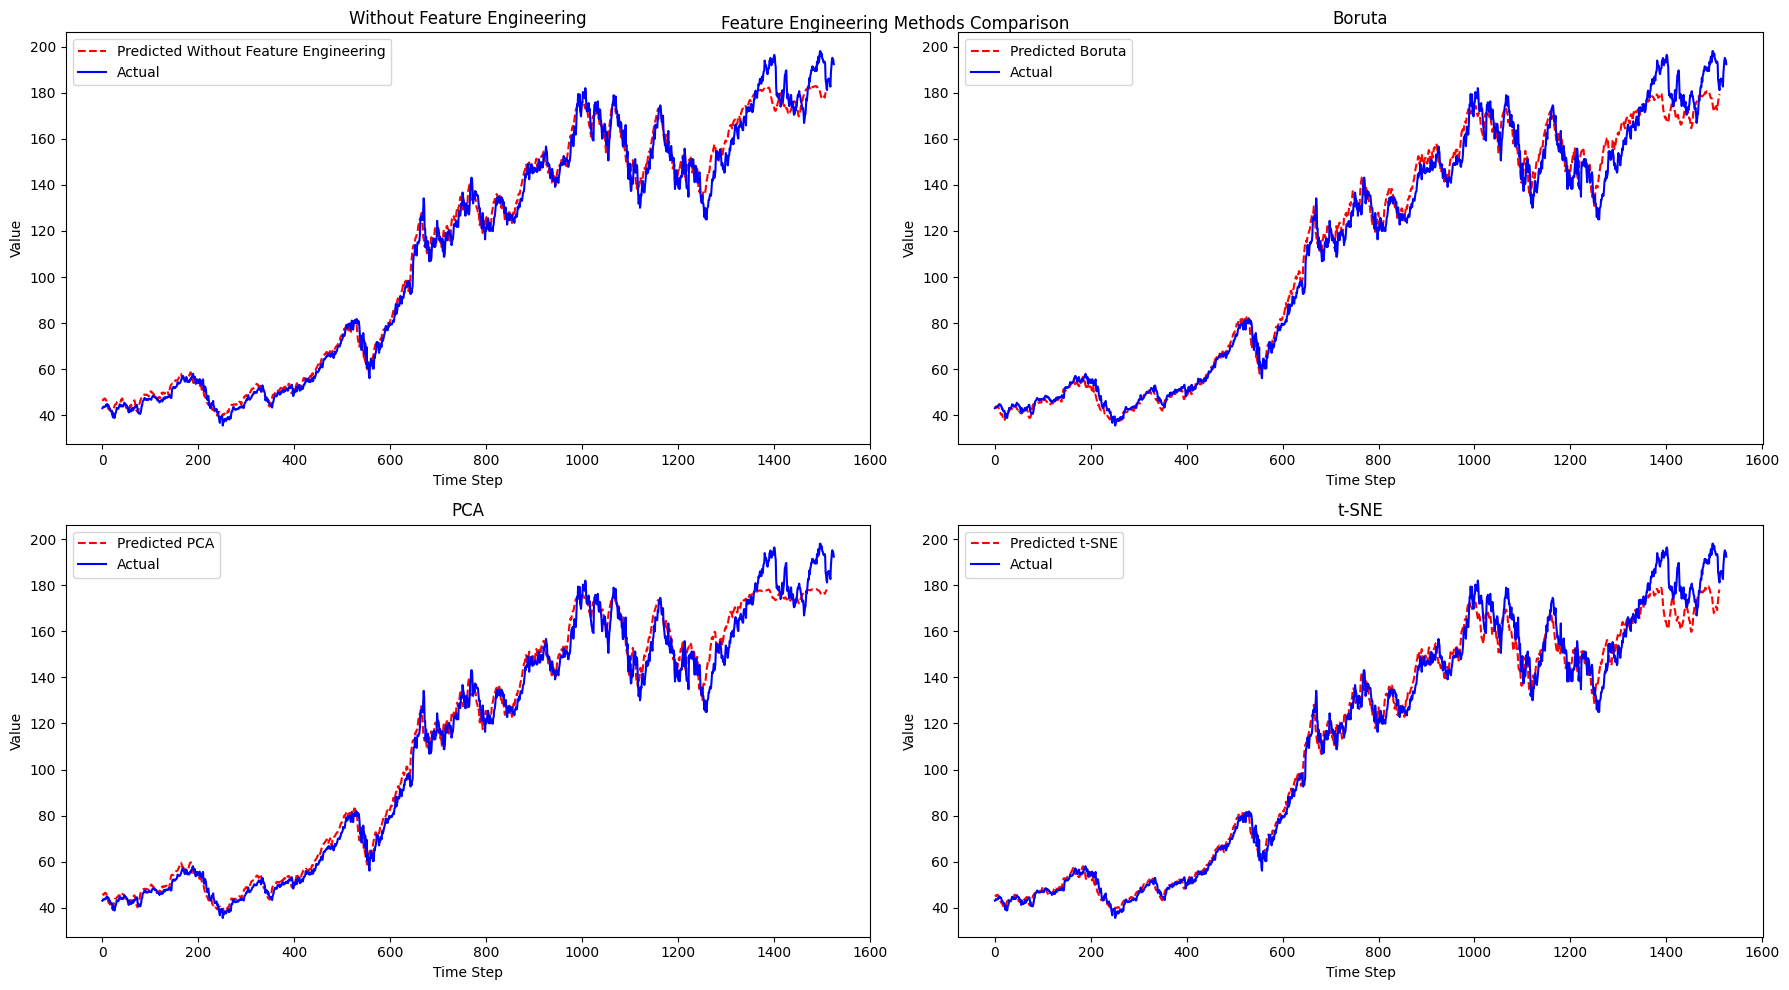

In [10]:
import matplotlib.pyplot as plt

# Assuming y_actual is prepared outside this snippet as suggested.
y_actual = np.concatenate((y_train, y_test), axis=0)

plt.figure(figsize=(18, 10))

for i, (method_name, pred_list) in enumerate(predictions_total.items(), start=1):
    # Concatenate train and test predictions for continuity
    predictions = np.concatenate((pred_list['train_pred'], pred_list['test_pred']), axis=0)

    # Plot
    plt.subplot(2, 2, i)
    plt.plot(predictions, label=f'Predicted {method_name}', linestyle='--', marker='', color='red')
    plt.plot(y_actual, label='Actual', linestyle='-', marker='', color='blue')
    plt.title(f'{method_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.suptitle('Feature Engineering Methods Comparison')
plt.show()


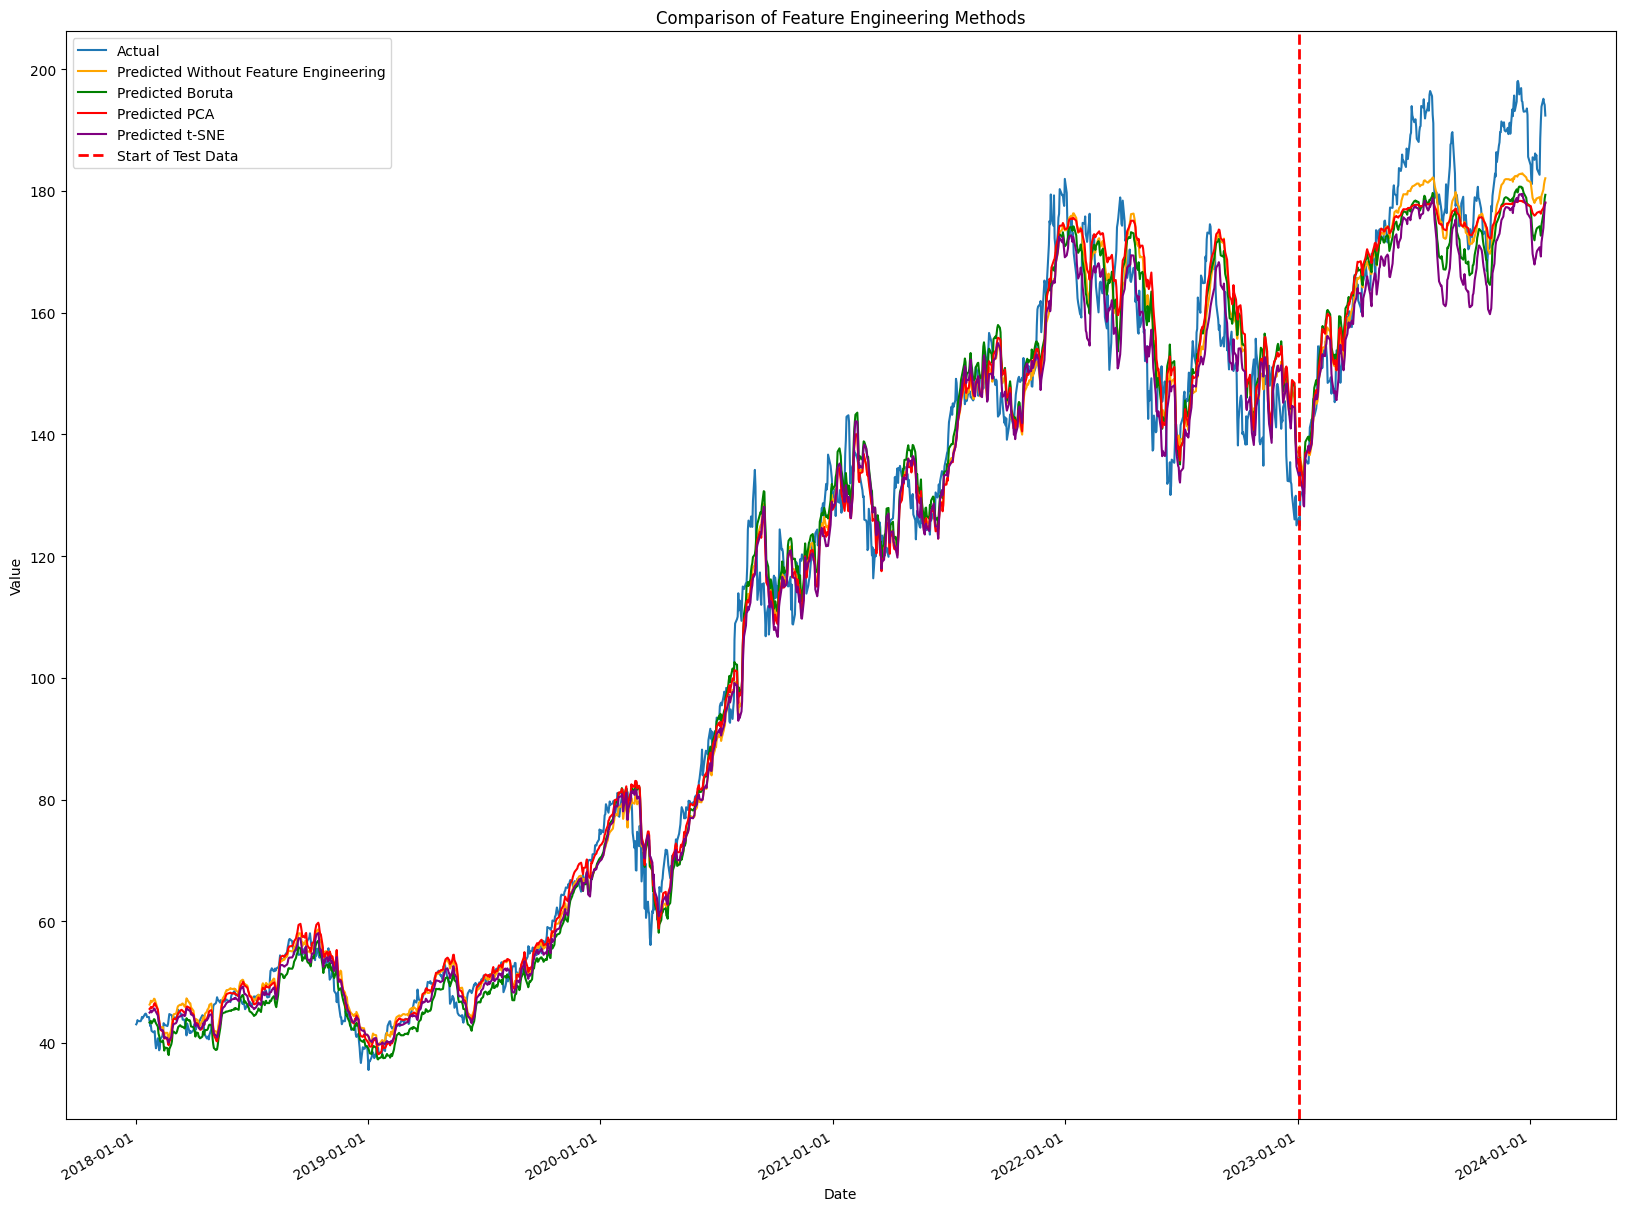

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()


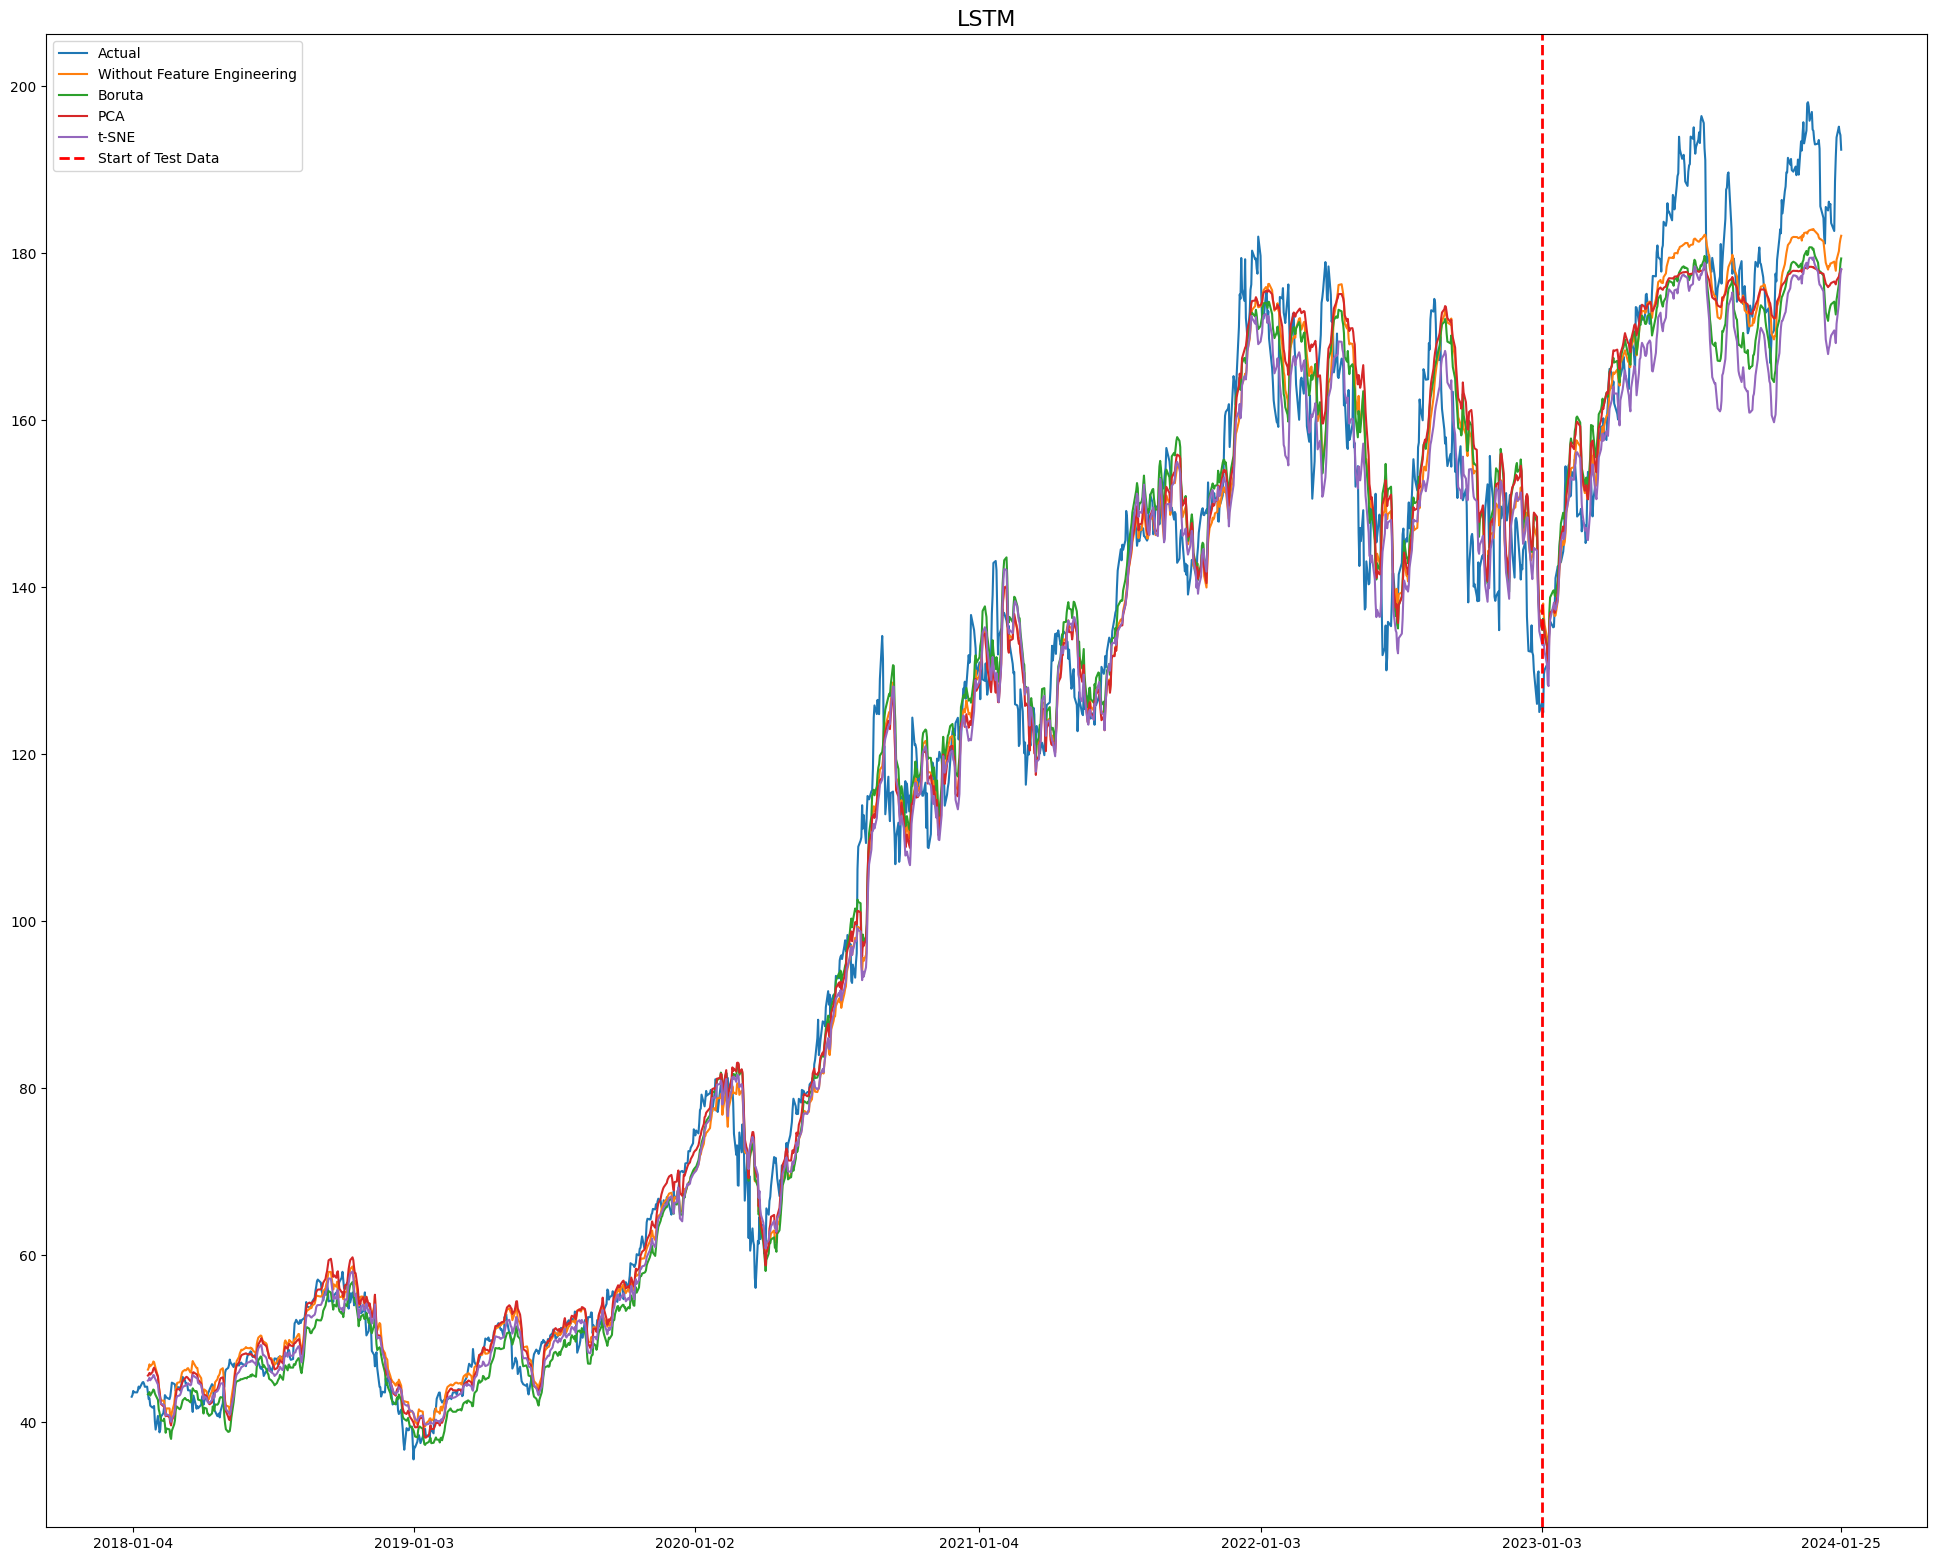

In [16]:
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)

date = pd.to_datetime(date)
plt.plot(date, y_actual, label='Actual')

for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))

    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))


    plt.plot(date, preds_combined, label=method)
    #plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
    plt.xticks(axis_x)
    plt.legend()

test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')
plt.legend()
# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.title('LSTM', fontsize=16)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd


dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}', color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()
